### <font color='blue'>Applied Data Science in Logistics with Spark SQL</font>

The objective of this work is to analyze the data and build graphs that answer the 10 questions below:

1. What is the number of incidents by gender?
2. What age group was most involved in the incidents?
3. What is the percentage of incidents by type of event (Incident Event Type)?
4. How did incidents per month evolve over time?
5. When the incident was “Collision Incident” in which month were there the highest number of incidents involving females?
6. What was the average number of incidents per month involving children (Child)?
7. Considering the incident description as “Injuries treated on scene” (Injury Result Description column), what is the total number of incidents involving males and females?
8. In 2017, in which month were there more incidents with the elderly (Elderly)?
9. Considering the Operator, what is the distribution of incidents over time?
10. What is the most common type of incident with cyclists?

In [1]:
# Python Language Version
from platform import python_version
print('Python Language Version Used in This Jupyter Notebook:', python_version())

Python Language Version Used in This Jupyter Notebook: 3.10.9


In [2]:
# Import findspark and initialize (to be able to use pyspark in jupyter notebook)
import findspark
findspark.init()

In [3]:
# Imports
import pyspark
import calendar
import seaborn as sns
import pandas  as pd
import numpy   as np
import plotly.express as px
from pyspark               import SparkContext
from pyspark.sql           import SparkSession
from pyspark.sql.functions import col, count, isnan, when
from pyspark.sql.functions import dayofmonth, month, dayofweek, concat_ws
from pyspark.sql.types     import NumericType, StringType
from pyspark.ml.feature    import VectorAssembler
from pyspark.ml.stat       import Correlation
from matplotlib import pyplot    as plt
from scipy      import stats     as ss

import warnings

# Disable display of warnings
warnings.filterwarnings("ignore")

In [4]:
# Package versions used in this jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib: 3.7.0
plotly    : 5.9.0
numpy     : 1.23.5
pandas    : 1.5.3
scipy     : 1.10.0
findspark : 2.0.1
pyspark   : 3.3.2
seaborn   : 0.12.2



In [5]:
# Initialize the Spark session

spark = SparkSession.builder \
    .appName("RiskAnalysisPublicTransport") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.7") \
    .getOrCreate()

23/07/25 15:20:36 WARN Utils: Your hostname, leonam-pc resolves to a loopback address: 127.0.1.1; using 192.168.93.217 instead (on interface wlx64700215b737)
23/07/25 15:20:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/leonam/anaconda3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/leonam/.ivy2/cache
The jars for the packages stored in: /home/leonam/.ivy2/jars
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0e6704ec-2acf-41cd-9ea6-9057b2118cee;1.0
	confs: [default]
	found com.crealytics#spark-excel_2.12;0.13.7 in central
	found org.apache.poi#poi;4.1.2 in central
	found commons-codec#commons-codec;1.13 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;4.1.2 in central
	found org.apache.poi#poi-ooxml-schemas;4.1.2 in central
	found org.apache.xmlbeans#xmlbeans;3.1.0 in central
	found com.github.virtuald#curvesapi;1.06 in central
	found com.norbitltd#spoiwo_2.12;1.8.0 in central
	found org.scala-lang.modules#scala-xml_2.12;1.3.0 in central
	found com.github.pjfanning#excel-streaming-reader;2.3.6 in central
	

23/07/25 15:20:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# View the spark_session object
spark

## Loading Data

In [7]:
# Read .xlsx file directly with PySpark
df = spark.read.format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("data/TFL_Bus_Safety.xlsx")

# 01 - Data Description

## 1.1. Visualizing the data

In [8]:
df.show(5)

+------+-------------------+-----+--------------+----------+--------------------+-------------------+-------------------------+-------------------+---------------+-----------+-----------+
|  Year|   Date Of Incident|Route|      Operator|Group Name|          Bus Garage|            Borough|Injury Result Description|Incident Event Type|Victim Category|Victims Sex|Victims Age|
+------+-------------------+-----+--------------+----------+--------------------+-------------------+-------------------------+-------------------+---------------+-----------+-----------+
|2015.0|2015-01-01 00:00:00|  1.0|London General|  Go-Ahead|Garage Not Available|          Southwark|     Injuries treated ...|   Onboard Injuries|      Passenger|       Male|      Child|
|2015.0|2015-01-01 00:00:00|  4.0|     Metroline| Metroline|Garage Not Available|          Islington|     Injuries treated ...|   Onboard Injuries|      Passenger|       Male|    Unknown|
|2015.0|2015-01-01 00:00:00|  5.0|   East London|Stagecoach|

## 1.2. Data Dimension

In [9]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 23158
Number of columns: 12


## 1.3. Data Types

In [10]:
df.printSchema()

root
 |-- Year: double (nullable = true)
 |-- Date Of Incident: timestamp (nullable = true)
 |-- Route: double (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Bus Garage: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Injury Result Description: string (nullable = true)
 |-- Incident Event Type: string (nullable = true)
 |-- Victim Category: string (nullable = true)
 |-- Victims Sex: string (nullable = true)
 |-- Victims Age: string (nullable = true)



## 1.4. Change Types

In [11]:
df = df.withColumn("Year", col("year").cast("int"))
df = df.withColumn("Route", col("Route").cast("int"))

## 1.5. Rename Columns

In [12]:
# Function to convert a column name to camel case
def to_lower_camel_case(name):
    words = name.split(' ')
    return words[0].lower() + ''.join(word.capitalize() for word in words[1:])

# Renames all columns to camel case
for col_name in df.columns:
    new_col_name = to_lower_camel_case(col_name)
    df = df.withColumnRenamed(col_name, new_col_name)

# Display column names after transformation
df.columns

['year',
 'dateOfIncident',
 'route',
 'operator',
 'groupName',
 'busGarage',
 'borough',
 'injuryResultDescription',
 'incidentEventType',
 'victimCategory',
 'victimsSex',
 'victimsAge']

## 1.6. Check NAs

In [13]:
# Check how many records have null values in each column
df.toPandas().isnull().sum()


year                       0
dateOfIncident             0
route                      0
operator                   0
groupName                  0
busGarage                  0
borough                    0
injuryResultDescription    0
incidentEventType          0
victimCategory             0
victimsSex                 0
victimsAge                 0
dtype: int64

# 2. Feature Engineering

In [14]:
# Creating new variables from 'dateOfIncident'
df = df.withColumn('month', month(df.dateOfIncident))
df = df.withColumn('day', dayofmonth(df.dateOfIncident))
df = df.withColumn('dayOfWeek', dayofweek(df.dateOfIncident))

# 3. Exploratory Data Analysis

## 3.1. Descriptive statistics

In [15]:
df.describe().show()

+-------+------------------+------------------+--------------+---------+----------+------------------+-----------------------+--------------------+--------------------+----------+----------+------------------+-----+------------------+
|summary|              year|             route|      operator|groupName| busGarage|           borough|injuryResultDescription|   incidentEventType|      victimCategory|victimsSex|victimsAge|             month|  day|         dayOfWeek|
+-------+------------------+------------------+--------------+---------+----------+------------------+-----------------------+--------------------+--------------------+----------+----------+------------------+-----+------------------+
|  count|             23158|             23158|         23158|    23158|     23158|             23158|                  23158|               23158|               23158|     23158|     23158|             23158|23158|             23158|
|   mean|2016.4496070472408|163.90586406425425|          nul

## 3.2. Univariate Analysis

In [16]:
# Get numeric columns
numerical_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
numerical_columns

['year', 'route', 'month', 'day', 'dayOfWeek']

In [17]:
# Get numeric columns
string_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
string_columns

['operator',
 'groupName',
 'busGarage',
 'borough',
 'injuryResultDescription',
 'incidentEventType',
 'victimCategory',
 'victimsSex',
 'victimsAge']

In [18]:
# Convert Spark DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()

### 3.2.1. Histograms

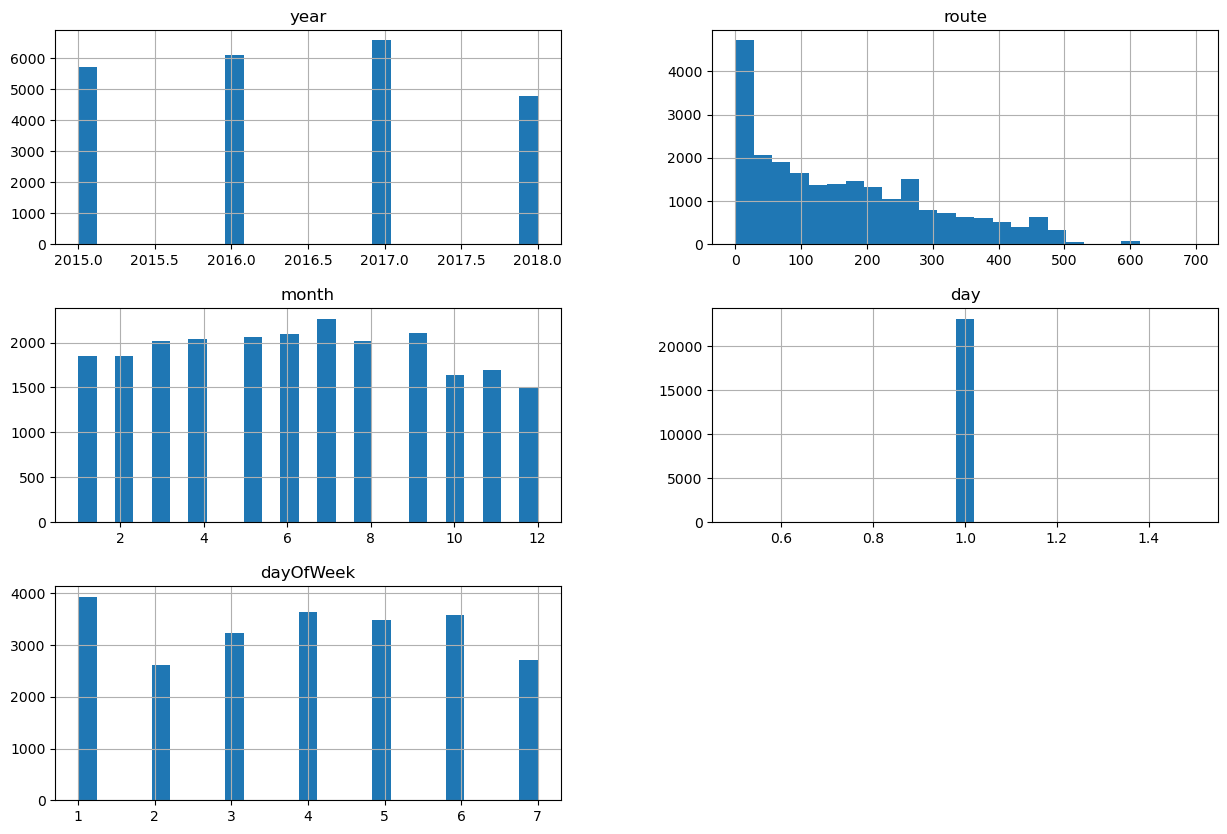

In [19]:
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot();

df_pandas.select_dtypes(include='number').hist(bins=25, ax=ax);


### 3.2.2. Box Plots

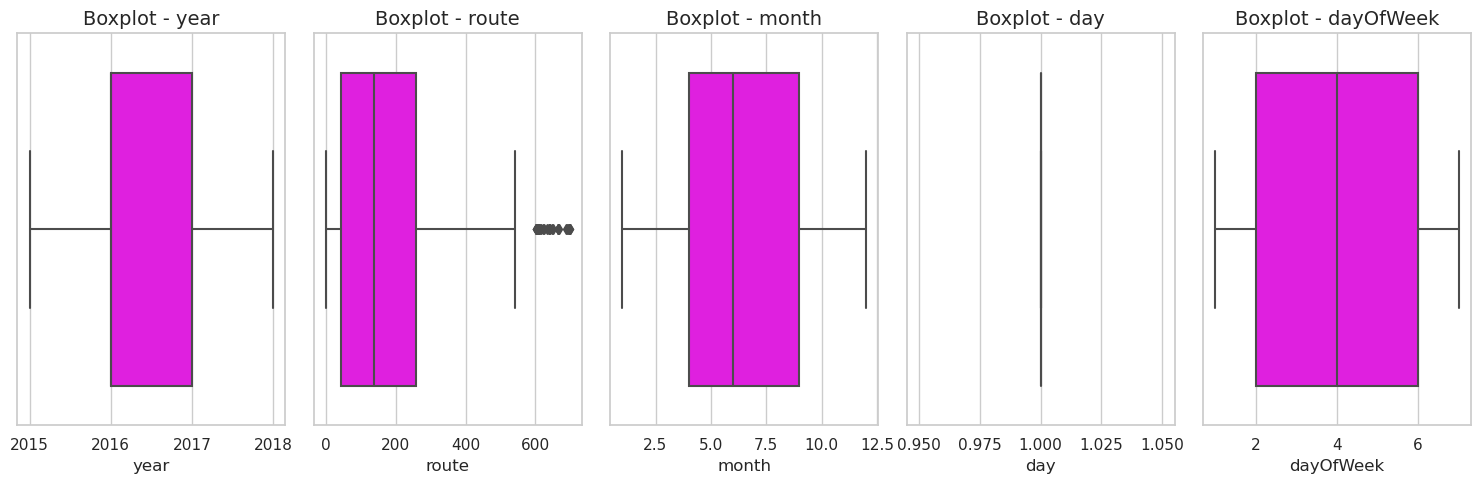

In [20]:
# Plot style setting
sns.set(style="whitegrid")

# Configure the subplots
fig, axes = plt.subplots(nrows=1, ncols=len(df_pandas.select_dtypes(include='number').columns), figsize=(15, 5), sharey=True)

# Generate the boxplots for each numeric variable
for idx, col in enumerate(df_pandas.select_dtypes(include='number').columns):
    sns.boxplot(x=col, data=df_pandas, ax=axes[idx], color='magenta')
    axes[idx].set_title(f"Boxplot - {col}", fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)

plt.tight_layout()  # To avoid overlapping elements
plt.show()

## 3.3. Multivariate Analysis

### 3.3.1. Numerical Variables

In [21]:
del numerical_columns[3]
numerical_columns

['year', 'route', 'month', 'dayOfWeek']

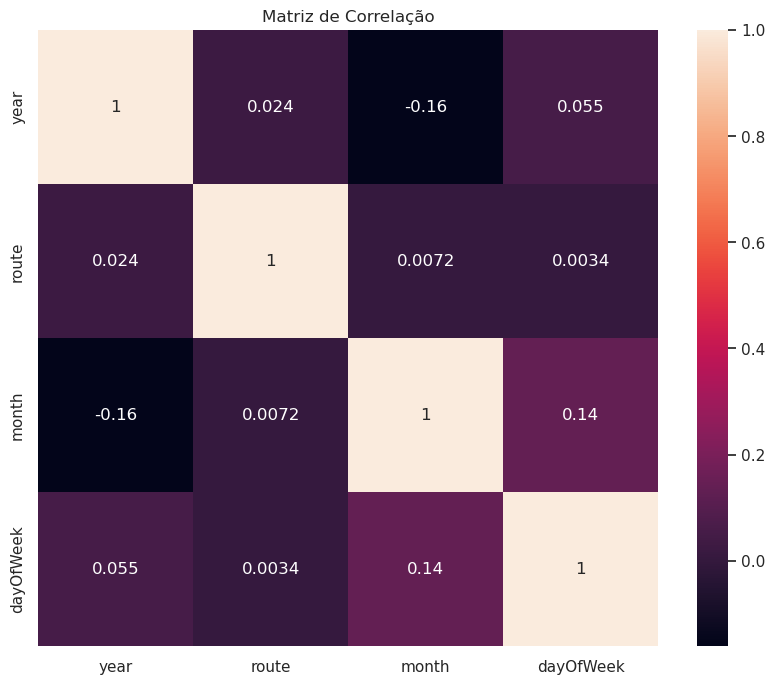

In [22]:
# Create a feature vector for the numeric columns
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
df_assembled = assembler.transform(df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, "features").head()

# Get the correlation matrix as an array
corr_array = correlation_matrix[0].toArray()

# Create a heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_array, annot=True, xticklabels=numerical_columns, yticklabels=numerical_columns)
plt.title('Matriz de Correlação')
plt.show()

### 3.3.2. Categorical Variables

In [23]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    # \chi ^{2} is derived from Pearson's chi-squared test
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    phi2corr  = max(0, phi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)

    # Varia de 0 a 1
    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

<Axes: >

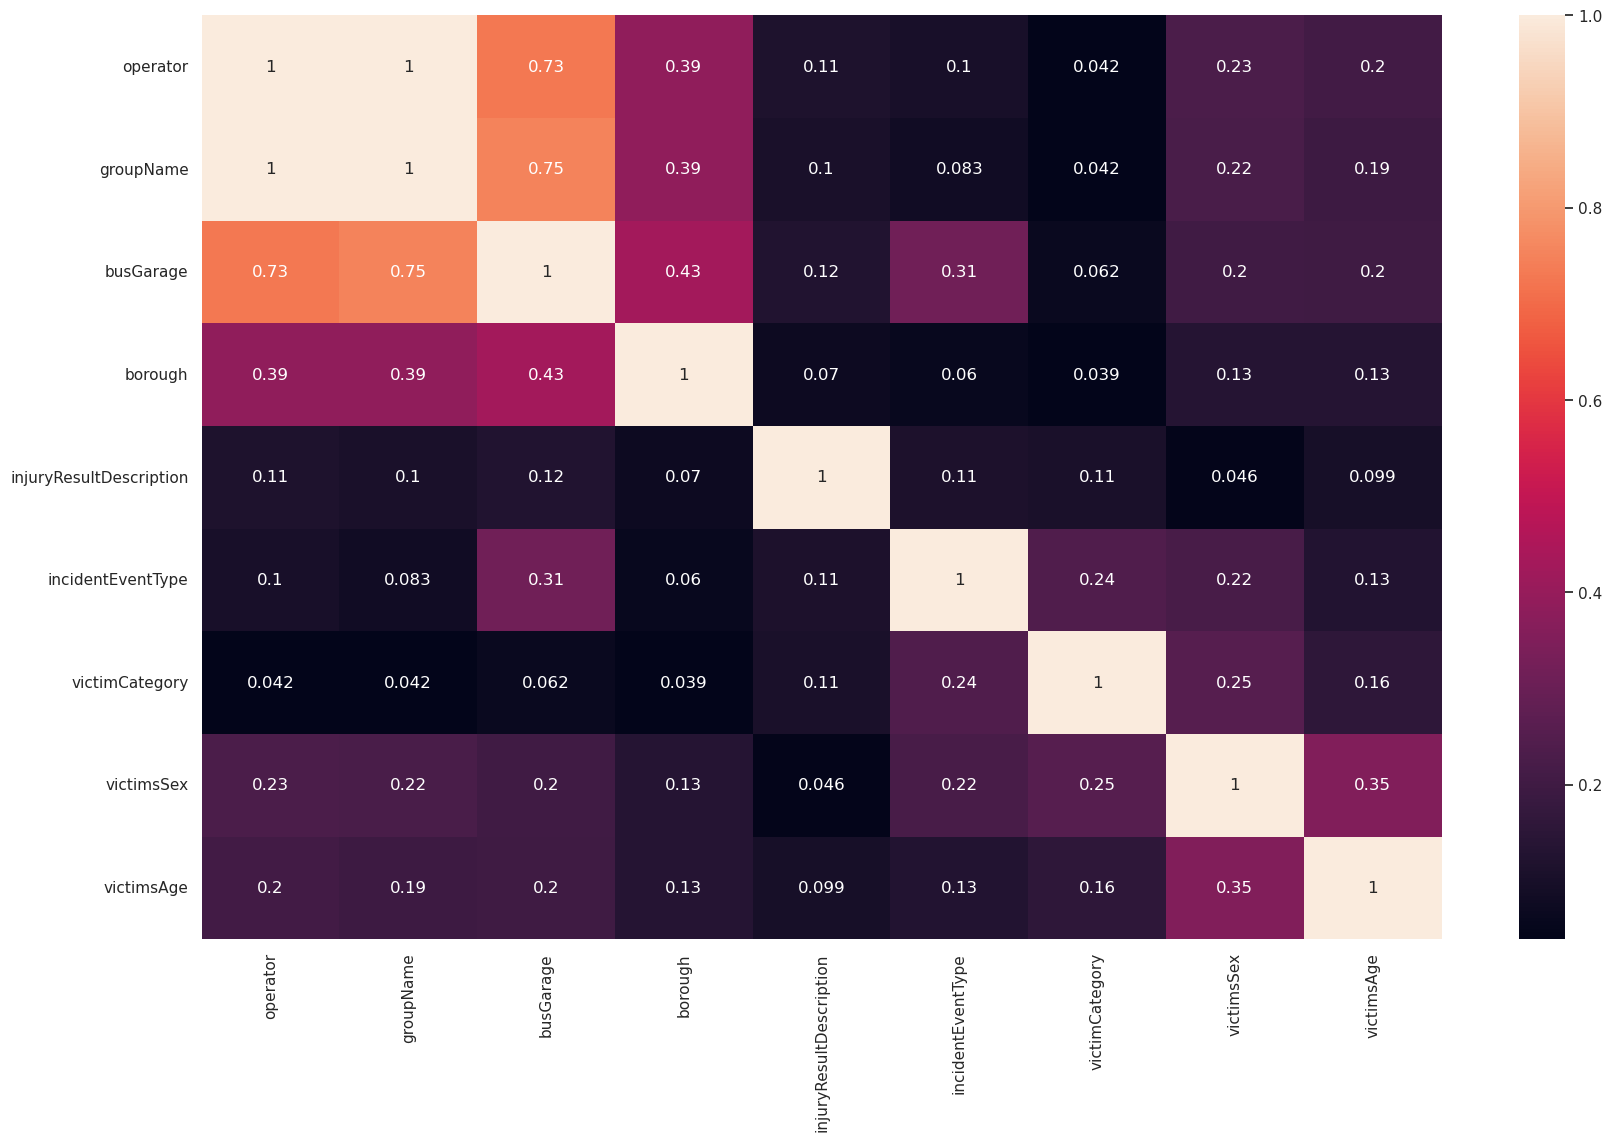

In [24]:
corr_dict = {}

for i in range(len(string_columns)):
    corr_list = []
    ref = string_columns[i]
    for j in range(len(string_columns)):
        feat = string_columns[j]
        corr = cramer_v(df_pandas[ref], df_pandas[feat])
        corr_list.append(corr)

    corr_dict[ref] = corr_list
    
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

d =  pd.DataFrame(corr_dict)
d = d.set_index( d.columns )
sns.heatmap(d, annot = True, ax=ax)

# 4. Business Questions

## Create temporary table

We create a temporary table to run SQL queries on the data. The temp table only exists in this session.

In [25]:
# Create temporary table
df.createOrReplaceTempView("tb_traffic_incidents")

## 1- What is the number of incidents by gender?

In [62]:
query = """
SELECT victimsSex, COUNT(*) as count
FROM tb_traffic_incidents
GROUP BY victimsSex
"""

# Execute the query
spark.sql(query).show()

+----------+-----+
|victimsSex|count|
+----------+-----+
|    Female|11847|
|   Unknown| 3602|
|      Male| 7709|
+----------+-----+



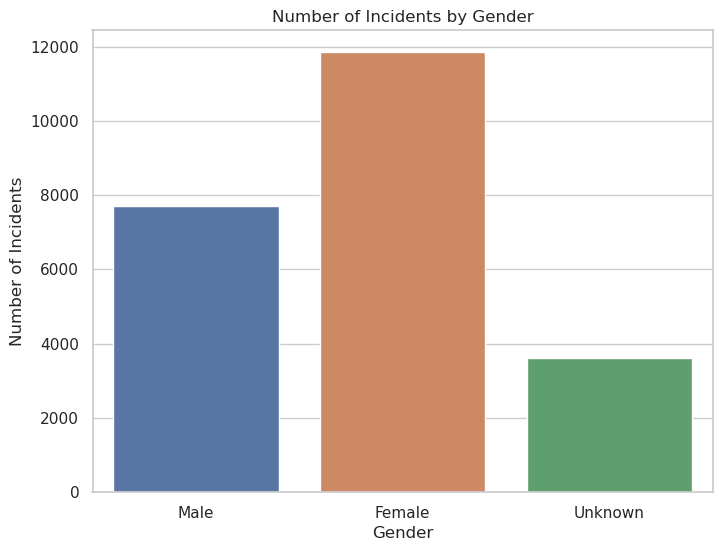

In [63]:
plt.figure(figsize=(8, 6))
sns.countplot(x='victimsSex', data=df_pandas)
plt.xlabel('Gender')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Gender')
plt.savefig('img/plot1.png')
plt.show()

## 2. What age group was most involved in the incidents?

In [64]:
query = """
SELECT victimsAge, COUNT(*) as count
FROM tb_traffic_incidents
GROUP BY victimsAge
ORDER BY COUNT DESC
LIMIT 1
"""

# Execute the query
spark.sql(query).show()

+----------+-----+
|victimsAge|count|
+----------+-----+
|     Adult|10754|
+----------+-----+



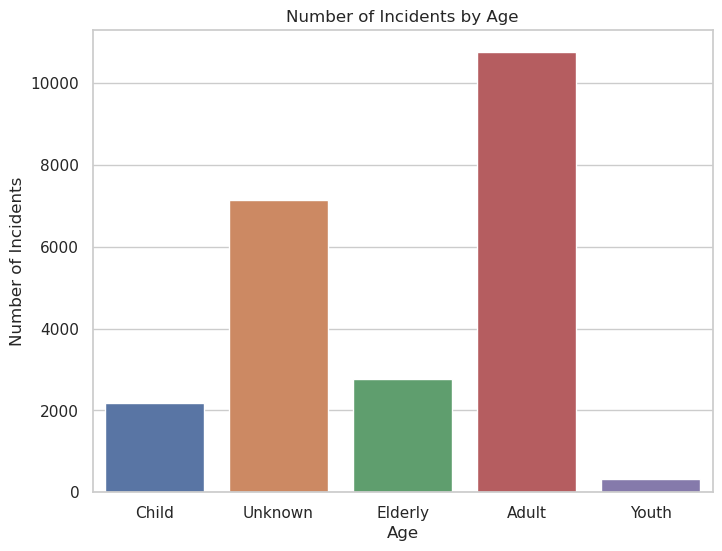

In [65]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_pandas, x=df_pandas.victimsAge)
plt.xlabel('Age')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Age')
plt.savefig('img/plot2.png')
plt.show()

## 3. What is the percentage of incidents by type of event (Incident Event Type)?

In [66]:
query = """
SELECT 
    incidentEventType,
    incidentCount,
    100 * incidentCount / (SELECT COUNT(*) FROM tb_traffic_incidents) AS percentage
FROM 
    (SELECT 
        incidentEventType,
        COUNT(*) AS incidentCount
    FROM 
        tb_traffic_incidents
    GROUP BY 
        incidentEventType)
ORDER BY percentage DESC
"""

# Execute the query
spark.sql(query).show()

+--------------------+-------------+--------------------+
|   incidentEventType|incidentCount|          percentage|
+--------------------+-------------+--------------------+
|      Slip Trip Fall|         6981|  30.145090249589774|
|    Onboard Injuries|         6563|  28.340098454097937|
|     Personal Injury|         4596|   19.84627342602988|
|  Collision Incident|         4166|   17.98946368425598|
|             Assault|          590|   2.547715692201399|
|Activity Incident...|          114| 0.49227048967959236|
|Vandalism Hooliga...|           73|   0.315225839882546|
|Safety Critical F...|           66| 0.28499870455134296|
|                Fire|            6|0.025908973141031178|
|             Robbery|            3|0.012954486570515589|
+--------------------+-------------+--------------------+



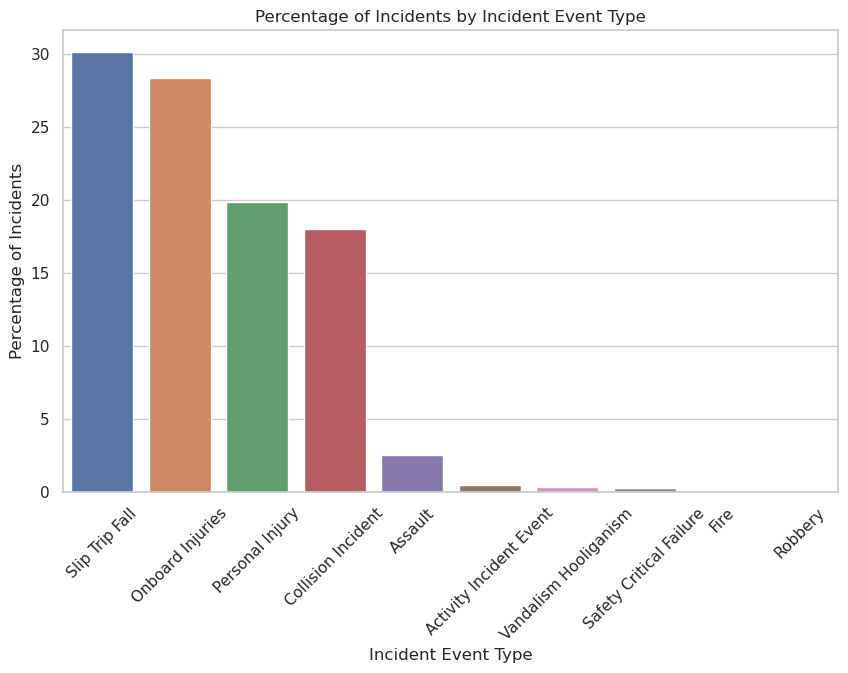

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(data=spark.sql(query).toPandas(), x="incidentEventType", y="percentage")
plt.xlabel('Incident Event Type')
plt.ylabel('Percentage of Incidents')
plt.title('Percentage of Incidents by Incident Event Type')
plt.xticks(rotation=45)  
plt.savefig('img/plot3.png')
plt.show()

## 4. How did incidents per month evolve over time?

In [32]:
query = """
SELECT
    year,
    month,
    CONCAT(year, '-', month) AS yearMonth,
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
GROUP BY
    year, month
ORDER BY
    year, month;
"""

# Execute the query
spark.sql(query).show()

+----+-----+---------+-------------+
|year|month|yearMonth|incidentCount|
+----+-----+---------+-------------+
|2015|    1|   2015-1|          399|
|2015|    2|   2015-2|          371|
|2015|    3|   2015-3|          460|
|2015|    4|   2015-4|          470|
|2015|    5|   2015-5|          472|
|2015|    6|   2015-6|          564|
|2015|    7|   2015-7|          558|
|2015|    8|   2015-8|          446|
|2015|    9|   2015-9|          487|
|2015|   10|  2015-10|          470|
|2015|   11|  2015-11|          495|
|2015|   12|  2015-12|          523|
|2016|    1|   2016-1|          466|
|2016|    2|   2016-2|          484|
|2016|    3|   2016-3|          449|
|2016|    4|   2016-4|          504|
|2016|    5|   2016-5|          494|
|2016|    6|   2016-6|          460|
|2016|    7|   2016-7|          507|
|2016|    8|   2016-8|          513|
+----+-----+---------+-------------+
only showing top 20 rows



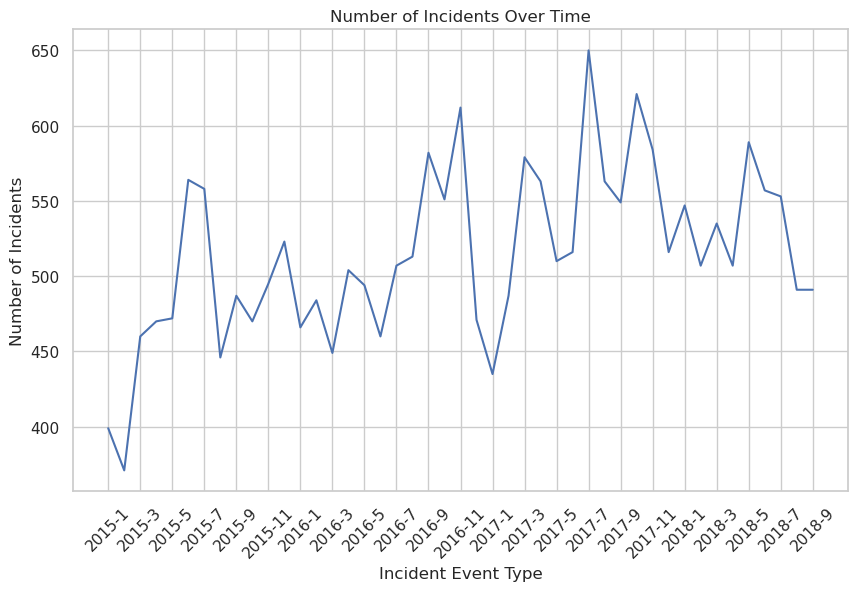

In [33]:
df_plot = spark.sql(query).toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x="yearMonth", y="incidentCount")
plt.xlabel('Incident Event Type')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents Over Time')
plt.xticks(df_plot.index[::2], df_plot['yearMonth'][::2], rotation=45)
plt.show()

## 5. When the incident was “Collision Incident” in which month were there the highest number of incidents involving females?

In [34]:
query = """
SELECT
    month,
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
WHERE
    incidentEventType = 'Collision Incident' AND
    victimsSex = 'Female'
GROUP BY
    month
ORDER BY
    incidentCount DESC;
"""

# Execute the query
spark.sql(query).show(1)

+-----+-------------+
|month|incidentCount|
+-----+-------------+
|    9|          158|
+-----+-------------+
only showing top 1 row



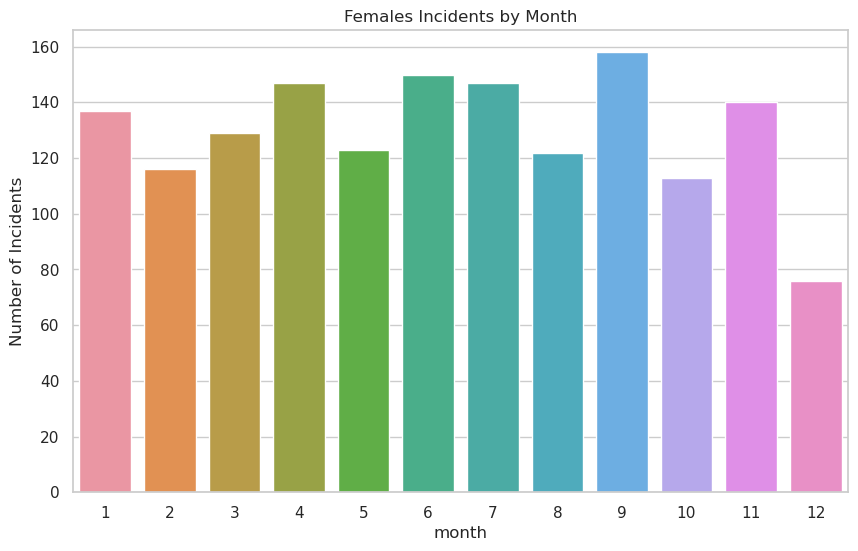

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(data=spark.sql(query).toPandas(), x="month", y="incidentCount")
plt.xlabel('month')
plt.ylabel('Number of Incidents')
plt.title('Females Incidents by Month')
plt.show()

## 6. What was the average number of incidents per month involving children (Child)?

In [36]:
query = """

SELECT DISTINCT
    month,
    AVG(COUNT(*)) OVER (PARTITION BY month) AS averageIncidents
FROM
    tb_traffic_incidents
WHERE
    victimsAge = 'Child'
GROUP BY
    month, year
ORDER BY
    month;

"""

# Execute the query
spark.sql(query).show()

+-----+------------------+
|month|  averageIncidents|
+-----+------------------+
|    1|              31.5|
|    2|              36.5|
|    3|              47.5|
|    4|              56.5|
|    5|              51.5|
|    6|             61.25|
|    7|              58.0|
|    8|              52.0|
|    9|             56.25|
|   10|              50.0|
|   11|              40.0|
|   12|35.666666666666664|
+-----+------------------+



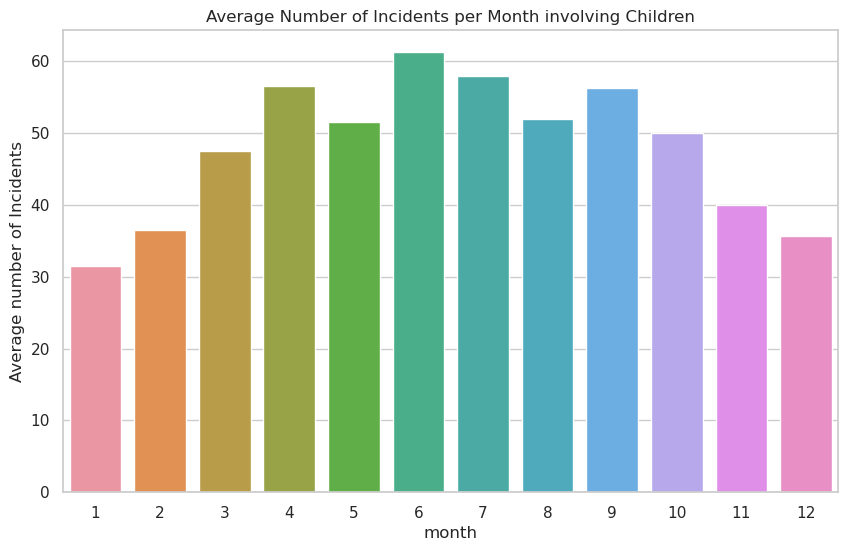

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(data=spark.sql(query).toPandas(), x="month", y="averageIncidents")
plt.xlabel('month')
plt.ylabel('Average number of Incidents')
plt.title('Average Number of Incidents per Month involving Children')
plt.show()

## 7. Considering the incident description as “Injuries treated on scene” (Injury Result Description column), what is the total number of incidents involving males and females?

In [38]:
query = """
SELECT
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
WHERE
    injuryResultDescription = 'Injuries treated on scene' AND
    victimsSex in ('Female' , 'Male')
"""

# Execute the query
spark.sql(query).show()

+-------------+
|incidentCount|
+-------------+
|        14448|
+-------------+



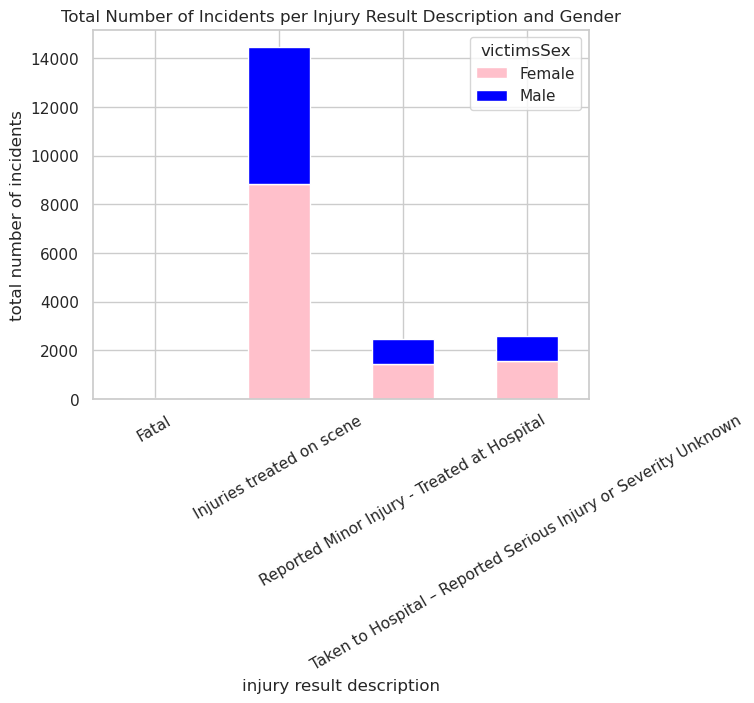

In [39]:
grouped_df = pd.crosstab(df_pandas['injuryResultDescription'], df_pandas['victimsSex'])
del grouped_df['Unknown']

grouped_df.plot(kind = 'bar', stacked = True, color = ['pink', 'blue'])
plt.xlabel('injury result description')
plt.ylabel('total number of incidents')
plt.title('Total Number of Incidents per Injury Result Description and Gender')
plt.xticks(rotation=30)  
plt.show()

## 8. In 2017, in which month were there more incidents with the elderly (Elderly)?

In [40]:
query = """
SELECT
    month,
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
WHERE
    year = 2017 AND
    victimsAge = 'Elderly'
GROUP BY
    month
ORDER BY incidentCount DESC
"""

# Execute the query
spark.sql(query).select('month').show(1)

+-----+
|month|
+-----+
|    7|
+-----+
only showing top 1 row



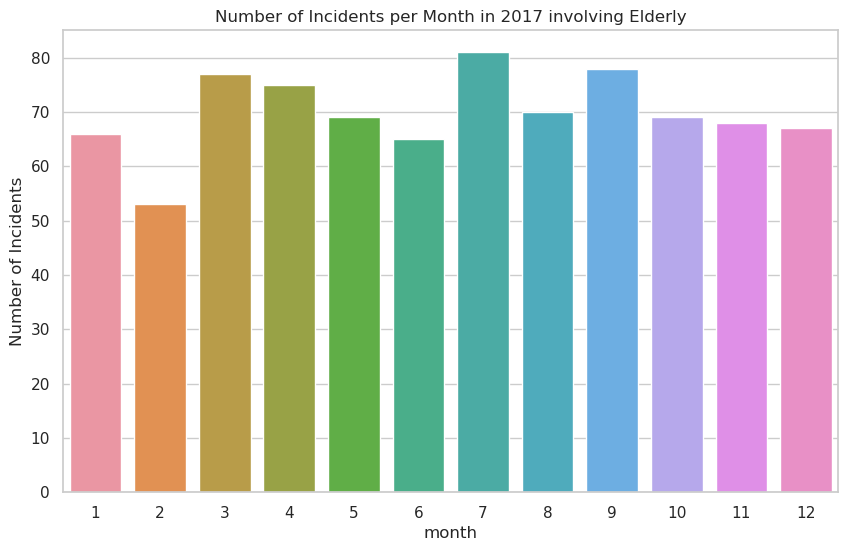

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=spark.sql(query).toPandas(), x="month", y="incidentCount")
plt.xlabel('month')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents per Month in 2017 involving Elderly')
plt.show()

## 9. Considering the Operator, what is the distribution of incidents over time?

In [42]:
query = """
SELECT
    year,
    month,
    CONCAT(year, '-', month) AS yearMonth,
    operator,
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
GROUP BY
    year, month, operator
ORDER BY
    year, month, operator;
"""

# Execute the query
spark.sql(query).show()

+----+-----+---------+--------------------+-------------+
|year|month|yearMonth|            operator|incidentCount|
+----+-----+---------+--------------------+-------------+
|2015|    1|   2015-1|      Abellio London|           11|
|2015|    1|   2015-1|        Abellio West|            1|
|2015|    1|   2015-1|Arriva Kent Thame...|           14|
|2015|    1|   2015-1| Arriva London North|           57|
|2015|    1|   2015-1| Arriva London South|           27|
|2015|    1|   2015-1|   Arriva The Shires|           11|
|2015|    1|   2015-1| Blue Triangle Buses|            2|
|2015|    1|   2015-1|     Docklands Buses|            6|
|2015|    1|   2015-1|         East London|            4|
|2015|    1|   2015-1|        H R Richmond|            4|
|2015|    1|   2015-1|      London Central|           22|
|2015|    1|   2015-1|      London General|           43|
|2015|    1|   2015-1|       London United|           67|
|2015|    1|   2015-1|            Metrobus|           12|
|2015|    1|  

In [43]:
# Criar um gráfico de linha interativo com o plotly
fig = px.line(spark.sql(query).toPandas(), x='yearMonth', y='incidentCount', color='operator',
              labels={'yearMonth': 'Date', 'incidentCount': 'Number of Incidents', 'operator': 'Operator'})

# Personalizar o layout do gráfico
fig.update_layout(title='Distribution of Incidents by Operator over Time',
                  xaxis_tickangle=-45, legend_title_text='Operator', width=1200, height=600)

# Mostrar o gráfico interativo
fig.show()


## 10. What is the most common type of incident with cyclists?

In [44]:
query = """

SELECT
    incidentEventType,
    COUNT(*) AS incidentCount
FROM
    tb_traffic_incidents
WHERE
    victimCategory = 'Cyclist' 
GROUP BY
    incidentEventType
ORDER BY
    incidentCount DESC

"""

# Execute the query
spark.sql(query).select("incidentEventType").show(1)

+------------------+
| incidentEventType|
+------------------+
|Collision Incident|
+------------------+
only showing top 1 row



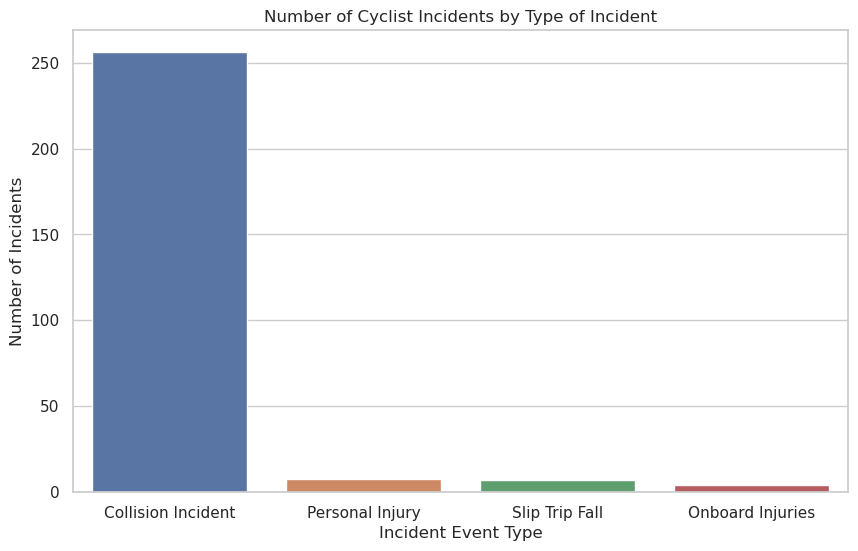

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(data=spark.sql(query).toPandas(), x="incidentEventType", y="incidentCount")
plt.xlabel('Incident Event Type')
plt.ylabel('Number of Incidents')
plt.title('Number of Cyclist Incidents by Type of Incident')
plt.show()